In [2]:
# ! pip install pymc3

In [71]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np
from sklearn.inspection import permutation_importance

In [33]:
# import pymc3 as pm
# import theano.tensor as tt
# import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [115]:
data=pd.read_csv("Wine_Quality_Data.csv")

In [116]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [117]:
data['quality']=np.where(data['quality']>5,1,0)

In [118]:
data['quality'].value_counts()

1    4113
0    2384
Name: quality, dtype: int64

In [119]:
target=data['quality']

In [120]:
data = data.drop(['quality'], axis=1)

In [121]:
data['color']=np.where(data['color']=='red',1,0)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, random_state=42)

In [85]:
# feature_names = [f"feature {i}" for i in range(data.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [86]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=data.columns)#feature_names)

Elapsed time to compute the importances: 5.286 seconds


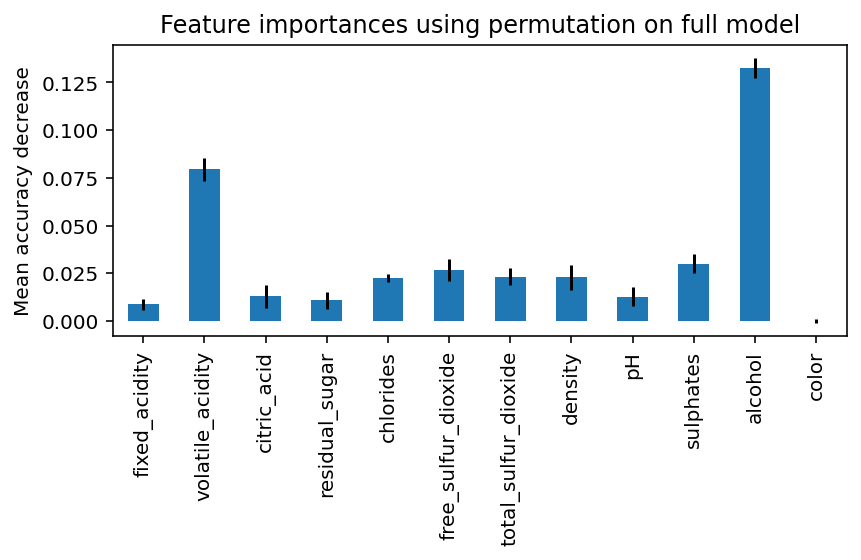

In [87]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [122]:
data['alcohol']=np.where(data['alcohol']<10,1,data['alcohol'])
data['alcohol']=np.where((data['alcohol']>=10)&(data['alcohol']<11),2,data['alcohol'])
data['alcohol']=np.where((data['alcohol']>=11)&(data['alcohol']<12),3,data['alcohol'])
data['alcohol']=np.where(data['alcohol']>=12,4,data['alcohol'])

In [123]:
data['alcohol'].value_counts().sort_values()

4.0     975
3.0    1211
2.0    1708
1.0    2603
Name: alcohol, dtype: int64

## Pooled

In [153]:
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, random_state=42)

In [154]:
alc_train=X_train['alcohol']
X_train = X_train.drop(['alcohol'], axis=1)
alc_test=X_test['alcohol']
X_test = X_test.drop(['alcohol'], axis=1)

In [155]:
data_tensor = thno.shared(X_train.values.astype('float64')) #<--error was without ".values" method
target_tensor = thno.shared(y_train.values.astype('int64'))
alc_tensor = thno.shared(alc_train.values.astype('int64'))

In [156]:
y = T.cast(data_tensor, 'int32')
y.eval()

array([[ 6,  0,  0, ...,  3,  0,  0],
       [ 7,  0,  0, ...,  3,  0,  0],
       [ 7,  0,  0, ...,  3,  0,  0],
       ...,
       [10,  0,  0, ...,  2,  0,  0],
       [ 7,  0,  0, ...,  3,  0,  0],
       [ 5,  0,  0, ...,  3,  0,  1]])

In [157]:
X_train.shape

(4872, 11)

In [158]:
y = T.cast(target_tensor, 'int32')
y.eval()

array([1, 0, 1, ..., 1, 1, 1])

In [159]:
n_parameters=11

In [160]:
with pm.Model() as complete_model:
    betas = pm.Normal('betas', 0, sigma=10, shape=n_parameters)
    logistic_coef = [betas[i] * data_tensor.transpose()[i] for i in range(n_parameters)] #resolved-->#AttributeError: 'SharedVariable' object has no attribute 'transpose'
#     print(logistic_coef)
    
    likelihood = pm.math.sigmoid(logistic_coef)
#     print(likelihood)
    # Data likelihood    
    y = pm.Bernoulli('y', likelihood, observed=target_tensor)#resolved-->y_train #<--ValueError: Input dimension mis-match. (input[0].shape[1] = 6497, input[1].shape[1] = 4872)

with complete_model:
    complete_trace = pm.sample(5000, step=pm.Metropolis())
    complete_burned_trace = complete_trace[1000:]  

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [betas]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 216 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [168]:
# %%time
# plot_traces(complete_burned_trace, complete_model); #-->runs forever

In [164]:
# az.plot_trace(complete_burned_trace)

In [162]:
complete_burned_trace

<MultiTrace: 4 chains, 4000 iterations, 1 variables>

In [166]:
X_train.shape

(4872, 11)

In [151]:
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Normal('beta_0',  0, sigma=10)
    beta_va=pm.Normal('volatile_acidity', 0, sigma=10)
    beta_ca=pm.Normal('citric_acid', 0, sigma=10)
    beta_rs=pm.Normal('residual_sugar', 0, sigma=10)
    beta_chl=pm.Normal('chlorides', 0, sigma=10)
    beta_fsd=pm.Normal('free_sulfur_dioxide', 0, sigma=10)
    beta_tsd=pm.Normal('total_sulfur_dioxide', 0, sigma=10)    
    beta_d=pm.Normal('density', 0, sigma=10)
    beta_ph=pm.Normal('pH', 0, sigma=10)
    beta_sul=pm.Normal('sulphates', 0, sigma=10)
    beta_clr=pm.Normal('color', 0, sigma=10)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_va*X_train['volatile_acidity']+
                               beta_ca*X_train['citric_acid']+
                               beta_rs*X_train['residual_sugar']+
                               beta_chl*X_train['chlorides']+
                               beta_fsd*X_train['free_sulfur_dioxide']+
                               beta_tsd*X_train['total_sulfur_dioxide']+
                               beta_d*X_train['density']+
                               beta_ph*X_train['pH']+
                               beta_sul*X_train['sulphates']+
                               beta_clr*X_train['color']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("quality", p, observed=y_train)
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
#     trace=pm.sample(25000, step=step, start=start)
#     burned_trace=trace[15000:]
    trace=pm.sample(5000, step=step, start=start)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [color]
>Metropolis: [sulphates]
>Metropolis: [pH]
>Metropolis: [density]
>Metropolis: [total_sulfur_dioxide]
>Metropolis: [free_sulfur_dioxide]
>Metropolis: [chlorides]
>Metropolis: [residual_sugar]
>Metropolis: [citric_acid]
>Metropolis: [volatile_acidity]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 272 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [170]:
burned_trace['p']

array([[0.70652507, 0.57320042, 0.67105561, ..., 0.62653562, 0.7569962 ,
        0.56392468],
       [0.72217843, 0.58601331, 0.681905  , ..., 0.63939713, 0.76899638,
        0.58198177],
       [0.7194505 , 0.57416593, 0.69220515, ..., 0.63808296, 0.76869796,
        0.58138755],
       ...,
       [0.69839441, 0.52798504, 0.69211401, ..., 0.63607643, 0.80189632,
        0.53662573],
       [0.70444982, 0.53564938, 0.69815371, ..., 0.64229514, 0.80711265,
        0.54518765],
       [0.6941786 , 0.52311781, 0.68994434, ..., 0.63336501, 0.8010218 ,
        0.54534214]])

In [173]:
np.mean(burned_trace['p'])

0.6328255118441138

In [174]:
np.mean(burned_trace['p'], axis=0)

array([0.69314062, 0.56148476, 0.66009213, ..., 0.58606762, 0.77737379,
       0.55693978])

In [175]:
len(np.mean(burned_trace['p'], axis=0))

4872

In [172]:
az.summary(burned_trace, kind="stats")[:20]

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
beta_0,1.034,0.574,0.191,2.221
volatile_acidity,-4.015,0.306,-4.619,-3.478
citric_acid,0.217,0.238,-0.255,0.636
residual_sugar,0.010,0.008,-0.007,0.024
chlorides,-9.825,1.209,-12.150,-7.566
free_sulfur_dioxide,0.017,0.003,0.012,0.022
total_sulfur_dioxide,-0.014,0.001,-0.016,-0.012
density,-1.643,0.843,-3.217,-0.144
pH,0.934,0.254,0.498,1.463
sulphates,2.296,0.273,1.732,2.778


In [171]:
az.summary(burned_trace, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
beta_0,1.034,0.574,0.191,2.221
volatile_acidity,-4.015,0.306,-4.619,-3.478
citric_acid,0.217,0.238,-0.255,0.636
residual_sugar,0.010,0.008,-0.007,0.024
chlorides,-9.825,1.209,-12.150,-7.566
...,...,...,...,...
p[4867],0.559,0.022,0.521,0.603
p[4868],0.201,0.063,0.092,0.323
p[4869],0.586,0.031,0.522,0.638
p[4870],0.777,0.012,0.754,0.799


# GLM: Logistic Regression

https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html

In [49]:
import warnings

from collections import OrderedDict
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano as thno
import theano.tensor as T

from scipy import integrate
from scipy.optimize import fmin_powell

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [3]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [4]:
def run_models(df, upper_order=5):
    """
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    """

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1, upper_order + 1):

        nm = f"k{k}"
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print(f"\nRunning: {nm}")
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init="adapt_diag", return_inferencedata=True)

    return models, traces


def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = az.plot_trace(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in az.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(az.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )


def create_poly_modelspec(k=1):
    """
    Convenience function:
    Create a polynomial modelspec string for patsy
    """
    return (
        "income ~ educ + hours + age " + " ".join([f"+ np.power(age,{j})" for j in range(2, k + 1)])
    ).strip()

In [16]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [17]:
raw_data.shape

(32561, 15)

In [18]:
raw_data=raw_data[:5000]

In [19]:
data = raw_data[~pd.isnull(raw_data["income"])]
data[data["native-country"] == " United-States"].sample(5)
income = 1 * (data["income"] == " >50K")
data = data[["age", "educ", "hours"]]

# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income
income.value_counts()

0    3779
1    1221
Name: income, dtype: int64

In [34]:
data.head()

,age,educ,hours,age2,income
0,3.9,13,40,15.21,0
1,5.0,13,13,25.00,0
2,3.8,9,40,14.44,0
3,5.3,7,40,28.09,0
4,2.8,13,40,7.84,0


In [35]:
income

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    1
4997    1
4998    0
4999    0
Name: income, Length: 5000, dtype: int32

In [20]:
# g = seaborn.pairplot(data)
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# seaborn.heatmap(
#     corr,
#     mask=mask,
#     cmap=cmap,
#     vmax=0.3,
#     linewidths=0.5,
#     cbar_kws={"shrink": 0.5},
#     ax=ax,
# );

In [22]:
%%time
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "income ~ age + age2 + educ + hours", data, family=pm.glm.families.Binomial()
    )
#     trace = pm.sample(1000, tune=1000, init="adapt_diag")
    trace = pm.sample(1000, tune=500, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hours, educ, age2, age, Intercept]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 350 seconds.
The acceptance probability does not match the target. It is 0.8839691629332799, but should be close to 0.8. Try to increase the number of tuning steps.


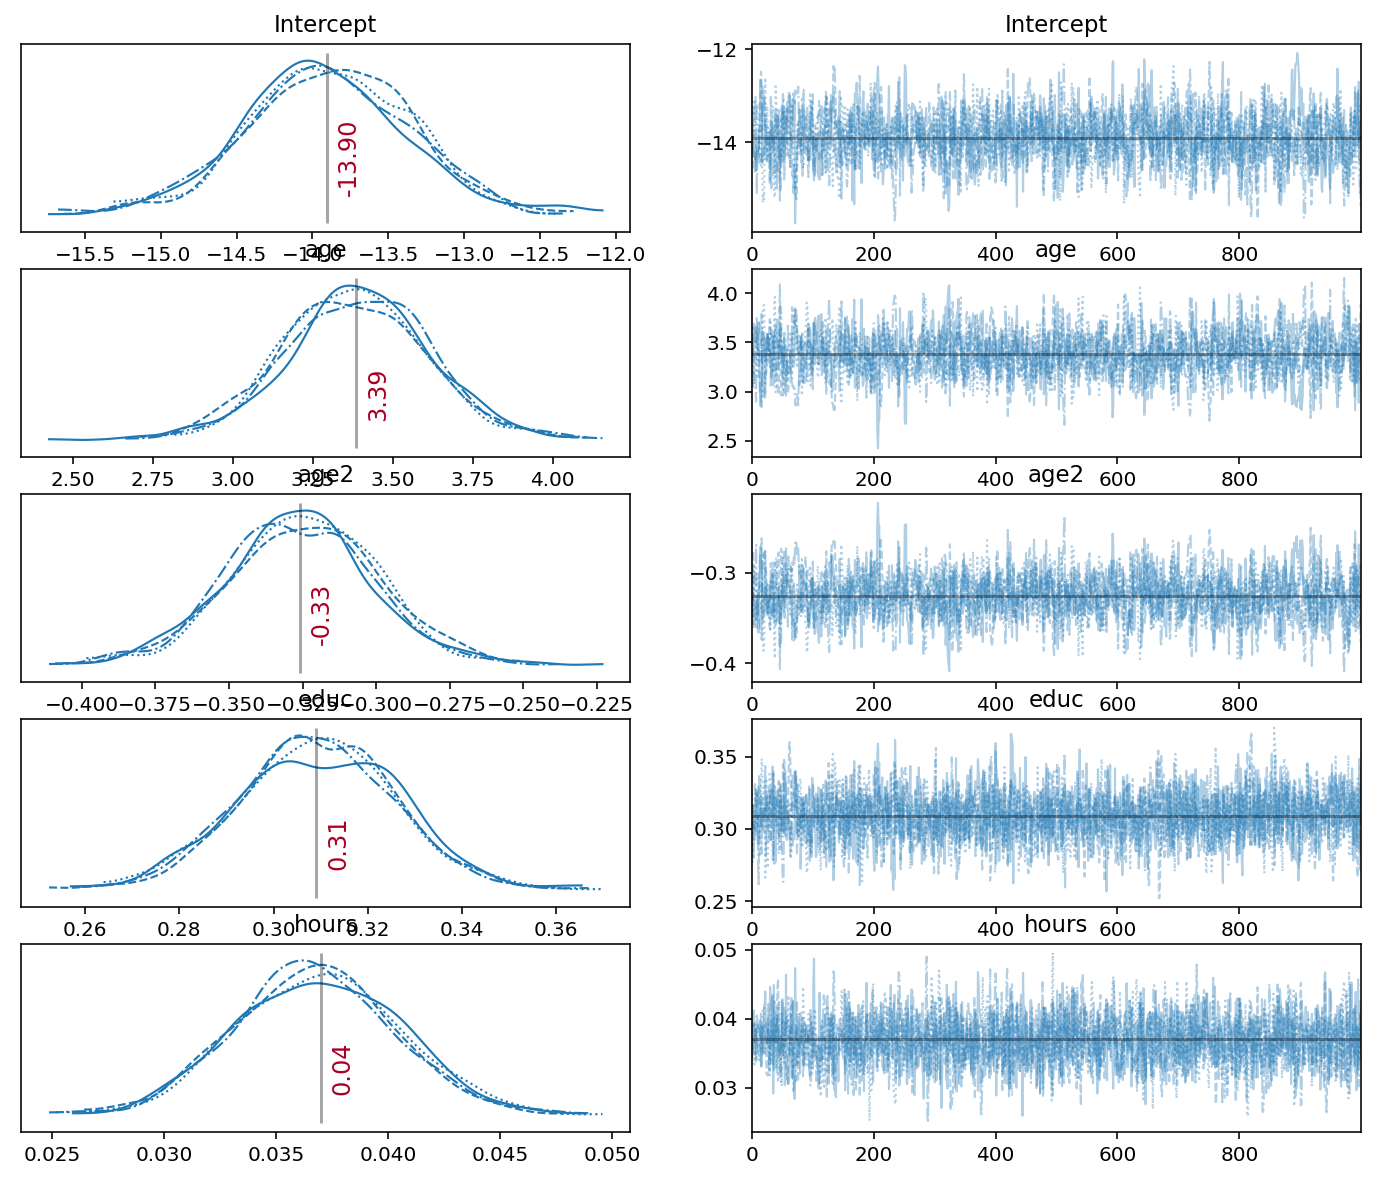

In [23]:
%%time
plot_traces(trace, logistic_model);

In [ ]:
# plt.figure(figsize=(9, 7))
# seaborn.jointplot(trace["age"], trace["educ"], kind="hex", color="#4CB391")
# plt.xlabel("beta_age")
# plt.ylabel("beta_educ");

In [24]:
def lm_full(trace, age, educ, hours):
    shape = np.broadcast(age, educ, hours).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age / 10.0, educ, hours]])
    return 1 / (
        1
        + np.exp(
            -(
                trace["Intercept"]
                + trace["age"] * x_norm[0]
                + trace["age2"] * (x_norm[0] ** 2)
                + trace["educ"] * x_norm[1]
                + trace["hours"] * x_norm[2]
            )
        )
    )


# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 12.0, 50.0)

# # Linear model with hours == 50 and educ == 16
# lm2 = lambda x, samples: lm_full(samples, x, 16.0, 50.0)

# # Linear model with hours == 50 and educ == 19
# lm3 = lambda x, samples: lm_full(samples, x, 19.0, 50.0)

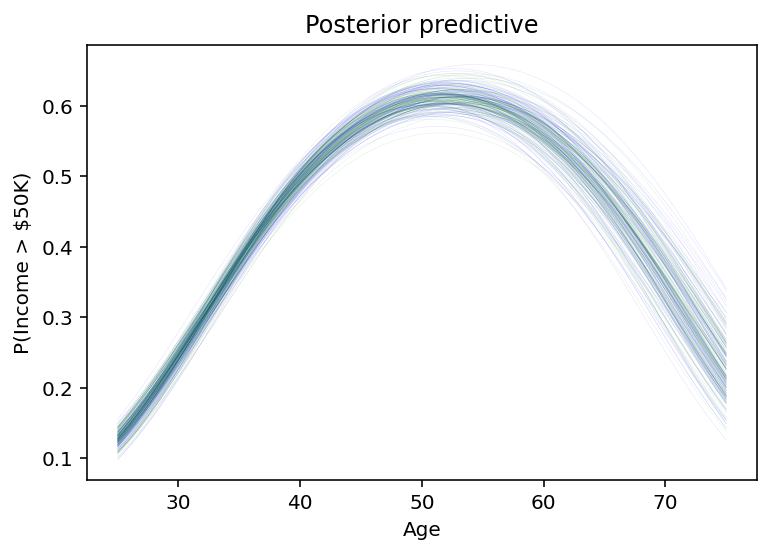

In [27]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    trace,
    eval=np.linspace(25, 75, 1000),
#     lm=lm2,
    lm=lm,
    samples=100,
    color="green",
    alpha=0.15,
)
# pm.plot_posterior_predictive_glm(
#     trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=0.15
# )

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm"], [], color="b", label="High School Education")
# green_line = mlines.Line2D(["lm2"], [], color="g", label="Bachelors")
# red_line = mlines.Line2D(["lm3"], [], color="r", label="Grad School")
# plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

In [ ]:
# b = trace["educ"]
# plt.hist(np.exp(b), bins=20, density=True)
# plt.xlabel("Odds Ratio")
# plt.show()
# lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

# print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

In [30]:
# models_lin, traces_lin = run_models(data, 3) #it works but runs several models (I commented out 2 of them..)

In [ ]:
# model_trace_dict = dict()
# for nm in ["k1", "k2", "k3"]:
#     model_trace_dict.update({nm: traces_lin[nm]})

# dfwaic = az.compare(model_trace_dict, ic="WAIC", scale="deviance")
# az.plot_compare(dfwaic);

In [33]:
#cell does not run
# %load_ext watermark
# %watermark -n -u -v -iv -w

# Bayesian logistic regression with PyMC3

age	educ	hours	age2	income

https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a

In [38]:
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_age=pm.Uniform('beta_age', lower, higher)
    beta_educ=pm.Uniform('beta_educ', lower, higher)
    beta_hours=pm.Uniform('beta_hours', lower, higher)
    beta_age2=pm.Uniform('beta_age2', lower, higher)
#     beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_age*data['age']+
                               beta_educ*data['educ']+
                               beta_hours*data['hours']+
                               beta_age2*data['age2']))
#                               +beta_humid_ratio*data['income']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("income", p, observed=income)
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
#     trace=pm.sample(25000, step=step, start=start)
#     burned_trace=trace[15000:]
    trace=pm.sample(1000, step=step, start=start)
    burned_trace=trace[500:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_age2]
>Metropolis: [beta_hours]
>Metropolis: [beta_educ]
>Metropolis: [beta_age]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
#not running because model above not found
# pm.traceplot(burned_trace)
# plt.show()

In [40]:
coeffs=['beta_0','beta_age','beta_educ','beta_hours','beta_age2']
d=dict()
for item in coeffs:
    d[item]=[burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs

,beta_0,beta_age,beta_educ,beta_hours,beta_age2
0,-13.936485,3.372955,0.307608,0.038143,-0.322967


In [45]:
# pm.stats.hpd(burned_trace['beta_0'])
#---
# Calculate HPD credible interval of 95%
ci_95 = az.hdi(burned_trace['beta_0'], hdi_prob=0.95)
#---
interval=dict()
for item in coeffs:
#     interval[item]=pm.stats.hpd(burned_trace[item]) #compute 95% high density interval
    interval[item]=az.hdi(burned_trace[item], hdi_prob=0.95)
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

,beta_0,beta_age,beta_educ,beta_hours,beta_age2
lower,-14.331473,3.288830,0.287711,0.033827,-0.333482
upper,-13.590450,3.455956,0.327793,0.043436,-0.310319


In [ ]:
# figsize(12.5, 12.5)
# seaborn.jointplot(burned_trace['beta_co2'], burned_trace['beta_humid_ration'], kind="hex") #color="#4CB391")
# plt.xlabel("beta_co2")
# plt.ylabel("beta_humid_ratio");

In [46]:
d=dict()
for item in coeffs:
    d[item]=[float(start[item])]
    
map_coeffs=pd.DataFrame.from_dict(d)    
map_coeffs

,beta_0,beta_age,beta_educ,beta_hours,beta_age2
0,-13.863932,3.372773,0.308664,0.03677,-0.324129


In [ ]:
# from sklearn.linear_model import LogisticRegression
# X=df.iloc[:, 1: -1]
# y=df['Occupancy']
# logit=LogisticRegression()
# logit_model=logit.fit(X,y)
# pd.DataFrame(logit_model.coef_, columns=X.columns)
# logit_prediction=logit_model.predict(X)
#compute the average probability of predicting 1. 
# y_score = np.mean(burned_trace['p'], axis=0)
#histogram of the distribution
# figsize(12.5,4)
# plt.hist(y_score, bins=40, density=True)
# plt.xlabel('Probability')
# plt.ylabel('Frequency')
# plt.title('Distribution of $y_score$')
# plt.show()
# first_model_prediction=[1 if x >0.5 else 0 for x in y_score]
# first_model_confussion_matrix =confusion_matrix(df['Occupancy'], first_model_prediction)
# first_model_confussion_matrix
# array([[1639,   54],
#        [   3,  969]])
# import sklearn
# from sklearn.metrics import classification_report
# print(sklearn.metrics.classification_report(y, first_model_prediction))
# pred_scores = dict(y_true=df['Occupancy'],y_score=y_score)
# roc_auc_score(**pred_scores)
# print(sklearn.metrics.classification_report(y, logit_prediction))

A different model with priors having normal distributions

In [ ]:
# with pm.Model() as second_model: 
#     #priors with normal distribution
#     beta_0=pm.Normal('beta_0', mu=0, sd=10**4)
#     beta_temp=pm.Normal('beta_temp', mu=0, sd=10**4)
#     beta_humid=pm.Normal('beta_humid', mu=0, sd=10**4)
#     beta_light=pm.Normal('beta_light', mu=0, sd=10**4)
#     beta_co2=pm.Normal('beta_co2', mu=0, sd=10**4)
#     beta_humid_ratio=pm.Normal('beta_humid_ration', mu=0, sd=10**4)
#     #probability of belonging to class 1
#     p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
#                                beta_humid*df['Humidity']+
#                                beta_light*df['Light']+
#                                beta_co2*df['CO2']+
#                                beta_humid_ratio*df['HumidityRatio']))
# #fit observed data into the model
# with second_model:
#     observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
#     start=pm.find_MAP()
#     step=pm.Metropolis()
#     second_trace=pm.sample(25000, step=step, start=start)
#     second_burned_trace=second_trace[15000:]
# pm.traceplot(second_burned_trace)
# plt.show()
# coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
# d=dict()
# for item in coeffs:
#     d[item]=[float(start[item])]
    
# second_map_coeffs=pd.DataFrame.from_dict(d)    
# second_map_coeffs
# figsize(12.5,4)
# plt.hist(burned_trace['beta_0']-second_burned_trace['beta_0'], bins=40, density=True)
# plt.title('Distribution of the difference between beta_0')
# plt.legend()
# plt.show()
# figsize(12.5,4)
# plt.hist(burned_trace['beta_temp'], label='First model', bins=40, density=True)
# plt.hist(second_burned_trace['beta_temp'], bins=40, label='Second model', density=True)
# plt.title('Distribution of of beta_temp')
# plt.legend()
# plt.show()
# second_y_score = np.mean(second_burned_trace['p'], axis=0)
# second_model_prediction=[1 if x >0.5 else 0 for x in second_y_score]
# second_model_confussion_matrix =confusion_matrix(df['Occupancy'], second_model_prediction)
# second_model_confussion_matrix
# figsize(12.5,4)
# plt.hist(y_score-second_y_score, bins=40)
# plt.title('Distribution of the difference between y_score and second_y_score')
# plt.ylabel('Frequency')
# plt.show()

A model with the built-in Generalized Linear Model (GLM).
In the previous sections, we use a hands-on approach to build our models. This is rather easy because we only have a few variables. When the number of variables is very large, it will not be very practical. Fortunately, PyMC3 has a built-in generalized linear model in which everything will be automated. Let us use this built-in model to fit our data.

In [ ]:
# with pm.Model() as third_model:
#     pm.glm.GLM.from_formula('Occupancy ~ Temperature + Humidity + Light + CO2 + HumidityRatio',
#                             df,
#                             family=pm.glm.families.Binomial())
#     third_trace = pm.sample(25000, tune=10000, init='adapt_diag')
# pm.traceplot(third_trace)
# plt.show()
# pm.summary(third_trace)
# with third_model:
#     map_solution=pm.find_MAP()
# d=dict()
# for item in map_solution.keys():
#     d[item]=[float(map_solution[item])]
    
# third_map_coeffs=pd.DataFrame.from_dict(d)    
# third_map_coeffs
# with third_model:
#     ppc = pm.sample_posterior_predictive(third_trace, samples=15000)
# #compute y_score 
# with third_model:
#     third_y_score = np.mean(ppc['y'], axis=0)
# #convert y_score into binary decisions    
# third_model_prediction=[1 if x >0.5 else 0 for x in third_y_score]
# #compute confussion matrix 
# third_model_confussion_matrix =confusion_matrix(df['Occupancy'], third_model_prediction)
# third_model_confussion_matrix
# figsize(12.5,4)
# plt.hist(third_y_score-second_y_score, bins=40)
# plt.title('Distribution of the difference between y_score and second_y_score')
# plt.ylabel('Frequency')
# plt.show()
# figsize(12.5,4)
# plt.hist(third_trace['Temperature'][-40000:]-second_burned_trace['beta_temp'], bins=40, density=True)
# plt.title('Difference between the temperature coefficients for the second and the third model')
# plt.show()
# figsize(12.5,4)
# plt.boxplot(third_trace['Humidity'][-40000:]-second_burned_trace['beta_humid'])
# plt.title('Difference between the humidity coefficients for the second and the third model')
# plt.show()

# Advanced usage of Theano in PyMC3

https://www.pymc.io/projects/docs/en/v3/Advanced_usage_of_Theano_in_PyMC3.html

In [56]:
thno.config.compute_test_value = "warn" #<this fixed the error in cell
#https://stackoverflow.com/questions/43835632/some-error-happened-when-i-run-the-example-code-in-the-theano-scan-api-guide
a = T.scalar('a')
# Create a new shared variable with initial value of 0.1
b = thno.shared(0.1)
func = thno.function([a], a * b)
# assert func(2.) == 0.2
func(2.) 
# b.set_value(10.)
# assert func(2.) == 20.

array(0.2)

We can use shared variables in PyMC3 to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [58]:
# We generate 10 datasets
true_mu = [np.random.randn() for _ in range(10)]
observed_data = [mu + np.random.randn(20) for mu in true_mu]

data = thno.shared(observed_data[0])
with pm.Model() as model:
    mu = pm.Normal('mu', 0, 10)
    pm.Normal('y', mu=mu, sigma=1, observed=data)

# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    # Switch out the observed dataset
    data.set_value(data_vals)
    with model:
        traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.8785942387527184, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883131920573449, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


We can also sometimes use shared variables to work around limitations in the current PyMC3 api. A common task in Machine Learning is to predict values for unseen data, and one way to achieve this is to use a shared variable for our observations:

In [78]:
x = np.random.randn(100)
y = x > 0

x_shared = thno.shared(x)
print(x_shared)
print(x_shared.get_value())
with pm.Model() as model:
  coeff = pm.Normal('x', mu=0, sigma=1)
  print(coeff)
  logistic = pm.math.sigmoid(coeff * x_shared)
  pm.Bernoulli('obs', p=logistic, observed=y)

  # fit the model
  trace = pm.sample()
#   trace = pm.sample(2000, tune=1000, init=None, cores=2, return_inferencedata=True)
    
  # Switch out the observations and use `sample_posterior_predictive` to predict
  x_shared.set_value([-1, 0, 1.])
  post_pred = pm.sample_posterior_predictive(trace, samples=500)

<TensorType(float64, vector)>
[ 0.34869432 -0.0647761   0.13825516 -0.16860934 -0.82080468 -1.15385505
 -0.72928832 -0.21628201  0.05219355  1.5140505  -2.48589717  0.06977775
 -0.79926604  0.81964812  0.59968408  1.19963772 -0.14100505  0.92538867
  0.13026289  1.59330801  0.88317176 -1.2949026  -0.39258336  2.76840381
  0.19447021 -1.14345021 -2.07114296 -0.32705144  0.45595987 -0.31081442
  1.40129569 -1.38424893 -0.7744973  -0.00878633 -1.90747234  0.25772563
 -0.93723641 -1.54928726 -0.9198985  -0.14299225 -0.45659909 -1.60595164
 -0.31796768  0.45866532 -1.92617673  0.58063195 -1.22707213 -0.99438459
  0.79885712 -1.12937747 -1.22718886  0.18217746 -0.04086726  0.04035009
 -0.90242352  1.86433883  0.23158724  0.86110565  0.08402257  0.2114898
  0.79001868 -0.9212954  -0.43249177  0.7875742  -1.30076564 -0.17332577
 -1.48022463 -0.78594306  1.16415556  0.07470575 -0.78837219  0.95113357
  0.14521864  1.4656466  -0.65170191  2.10775798 -0.02945588  0.83804402
  1.07849644  2.329011

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.8841918953457618, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855554288653888, but should be close to 0.8. Try to increase the number of tuning steps.


In [63]:
post_pred

{'obs': array([[0, 1, 0],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 1, 1],
        [1, 0, 1],
        [0, 1, 1]])}

Writing custom Theano Ops

In [64]:
from scipy import optimize, special
import numpy as np

def func(mu, theta):
    thetamu = theta * mu
    value = np.log(mu) + np.logaddexp(0, thetamu)
    return value

def jac(mu, theta):
    thetamu = theta * mu
    jac = theta * special.expit(thetamu) + 1 / mu
    return jac

def mu_from_theta(theta):
    return optimize.newton(func, 1, fprime=jac, args=(theta,))

In [65]:
import sympy

mu = sympy.Function('mu')
theta = sympy.Symbol('theta')
R = mu(theta) + mu(theta) * sympy.exp(theta * mu(theta)) - 1
solution = sympy.solve(R.diff(theta), mu(theta).diff(theta))[0]

In [68]:
# import theano.tests.unittest_tools #error
from theano.graph.op import Op

class MuFromTheta(Op):
    itypes = [T.dscalar]
    otypes = [T.dscalar]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = mu_from_theta(theta)
        outputs[0][0] = np.array(mu)

    def grad(self, inputs, g):
        theta, = inputs
        mu = self(theta)
        thetamu = theta * mu
        return [- g[0] * mu ** 2 / (1 + thetamu + T.exp(-thetamu))]

In [70]:
#does not run
# tt_mu_from_theta = MuFromTheta()

# with pm.Model() as model:
#     theta = pm.HalfNormal('theta', sigma=1)
#     mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
#     pm.Normal('y', mu=mu, sigma=0.1, observed=[0.2, 0.21, 0.3])

#     trace = pm.sample()